In [ ]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from ballmapper.pyBallMapper import BallMapper

In [ ]:
def generate_tpf(n=100, sigma=0.1):
    unif = ss.uniform()
    norm = ss.norm(loc=0, scale=sigma)
    x = unif.rvs(n)
    def tpf_(t):
        if t<0.3: return 2*t
        if t>0.7: return 1.4-t # perhaps 1.3-t?
        return 0.6
    y = list(map(tpf_, x))
    y += norm.rvs(n)
    return x, y

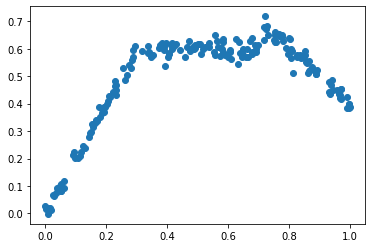

In [ ]:
x, y = generate_tpf(n=200, sigma=0.02)
plt.plot(x, y, 'o')

In [ ]:
def rmse_ols(n, sigma, mcloops=1000):
    rmses = []
    for mcloop in range(mcloops):
        x, y = generate_tpf(n=n, sigma=sigma)
        X = x.reshape(-1,1)
        lm = LinearRegression().fit(X,y)
        rmse = mean_squared_error(lm.predict(X), y, squared=False)
        rmses.append(rmse)
    return np.mean(rmses) 

In [ ]:
sigmas = [0.02, 0.2, 0.5]
ns = [200, 500, 1000, 2000]
mcloops = 1000
rmses = []
for sigma in sigmas:
    for n in ns:
        rmses.append([sigma, n, rmse_ols(n=n, sigma=sigma, mcloops=mcloops)])

In [ ]:
pd.DataFrame(rmses, columns=['sigma', 'n', 'OLS'])

,sigma,n,OLS
0,0.02,200,0.135165
1,0.02,500,0.136076
2,0.02,1000,0.136357
3,0.02,2000,0.136267
4,0.20,200,0.239125
5,0.20,500,0.240322
6,0.20,1000,0.240775
7,0.20,2000,0.241077
8,0.50,200,0.516054
9,0.50,500,0.516565


In [ ]:
# # This is *in-sample* only!
# def rmse_bmlr(x, y, epsilon, cut, r, substitution_policy = 'global'):
#     npts = x.shape[0]
#     dpts = x.shape[1]
#     betas = np.zeros((npts, dpts))
#     intercepts = np.zeros((npts, 1))
#     counts = np.zeros((npts, 1))

#     # fit global model first
#     lm_global = LinearRegression().fit(x, y)
#     for r_ in range(r):
#         bm = BallMapper(points=x, coloring_df=pd.DataFrame(y), epsilon=epsilon, shuffle=True)
#         for node_id in bm.Graph.nodes:
#             ball_pts_ind = bm.Graph.nodes[node_id]['points covered']
#             if len(ball_pts_ind) >= cut:
#                 x_ball = x[ball_pts_ind, :]
#                 y_ball = y[ball_pts_ind]
#                 lm = LinearRegression().fit(x_ball, y_ball)
#                 betas[ball_pts_ind, :] += lm.coef_
#                 intercepts[ball_pts_ind] += lm.intercept_
#             else:
#                 if substitution_policy == 'global':
#                     betas[ball_pts_ind, :] += lm_global.coef_
#                     intercepts[ball_pts_ind] += lm_global.intercept_
#                 else:
#                     # find nearest big ball
#                     min_dist = np.Inf
#                     min_id = None
#                     small_ball_mean = np.mean(x[ball_pts_ind, :], axis=0)
#                     for big_node_id in bm.Graph.nodes:
#                         big_pts_ids = bm.Graph.nodes[big_node_id]['points covered']
#                         if len(big_pts_ids) >= cut:
#                             big_ball_mean = np.mean(x[big_pts_ids, :], axis=0)
#                             dist = np.linalg.norm(small_ball_mean - big_ball_mean)
#                             if dist < min_dist:
#                                 min_dist = dist
#                                 min_id = big_node_id
#                     # make Linear Model in big ball
#                     if min_id == None:
#                         raise ValueError(f'All ball contain less than cut={cut} points. Decrease cut or increase epsilon!')
#                     big_pts_ids = bm.Graph.nodes[min_id]['points covered']
#                     lm_big = LinearRegression().fit(x[big_pts_ids, :], y[big_pts_ids])
#                     betas[ball_pts_ind, :] += lm_big.coef_
#                     intercepts[ball_pts_ind, :] += lm_big.intercept_    
#             counts[ball_pts_ind] += 1
            
#     intercepts /= counts
#     betas /= counts # FIXME: is this going to work for d > 1?

#     # make insample predictions
#     yhat = []
#     xt = np.transpose(x)
#     for i in range(npts):
#         yhat.append(np.matmul(betas[i, :], xt[:, i]) + intercepts[i][0])
    
#     rmse = mean_squared_error(yhat, y, squared=False)    
#     return rmse

In [63]:
# This is *in-sample* only!
class BMLR:
    def __init__(self, epsilon, cut, M):
        self.epsilon = epsilon
        self.cut = cut
        self.M = M
        self.betas = None
        self.intercepts = None
        self.counts_ = None
        self.npts = None
        self.dpts = None
        self.lm_global = LinearRegression()
        self.ball_mappers = []
        self.in_sample_remse = None
        
    def fit(self, x, y, substitution_policy = 'global'):
        self.npts = x.shape[0]
        self.dpts = x.shape[1]
        self.betas = np.zeros((self.npts, self.dpts))
        self.intercepts = np.zeros((self.npts, 1))
        self.counts_ = np.zeros((self.npts, 1))
        self.ball_mappers = []
        # fit global model
        if substitution_policy == 'global':
            self.lm_global.fit(x,y)
        
        for r_ in range(self.M):
            bm = BallMapper(points=x, coloring_df=pd.DataFrame(y), epsilon=self.epsilon, shuffle=False)
            # shuffle is False for debugging
            self.ball_mappers.append(bm)
            for node_id in bm.Graph.nodes:
                ball_pts_ind = bm.Graph.nodes[node_id]['points covered']
                if len(ball_pts_ind) >= self.cut:
                    x_ball = x[ball_pts_ind, :]
                    y_ball = y[ball_pts_ind]
                    lm = LinearRegression().fit(x_ball, y_ball)
                    self.betas[ball_pts_ind, :] += lm.coef_
                    self.intercepts[ball_pts_ind] += lm.intercept_
                    self.counts_[ball_pts_ind] += 1
                else:
                    raise ValueError('BREAK') # for debugging only
                    if substitution_policy == 'global':
                        self.betas[ball_pts_ind, :] += self.lm_global.coef_
                        self.intercepts[ball_pts_ind] += self.lm_global.intercept_
                        self.counts_[ball_pts_ind] += 1
                    else:
                        # find nearest big ball
                        min_dist = np.Inf
                        min_id = None
                        small_ball_mean = np.mean(x[ball_pts_ind, :], axis=0)
                        for big_node_id in bm.Graph.nodes:
                            big_pts_ids = bm.Graph.nodes[big_node_id]['points covered']
                            if len(big_pts_ids) >= self.cut:
                                big_ball_mean = np.mean(x[big_pts_ids, :], axis=0)
                                dist = np.linalg.norm(small_ball_mean - big_ball_mean)
                                if dist < min_dist:
                                    min_dist = dist
                                    min_id = big_node_id
                        # make Linear Model in big ball
                        if min_id == None:
                            raise ValueError(f'All ball contain less than cut={self.cut} points. Decrease cut or increase epsilon!')
                        big_pts_ids = bm.Graph.nodes[min_id]['points covered']
                        lm_big = LinearRegression().fit(x[big_pts_ids, :], y[big_pts_ids])
                        self.betas[ball_pts_ind, :] += lm_big.coef_
                        self.intercepts[ball_pts_ind, :] += lm_big.intercept_    
                        self.counts_[ball_pts_ind] += 1

        self.betas /= self.counts_ # FIXME: is this going to work for d > 1?
        self.intercepts /= self.counts_
        
        #print(self.intercepts[:20, :])
        
        # compute in-sample RMSE, this should be moved to separate function like score?
        # make insample predictions
        yhat = []
        xt = np.transpose(x)
        for i in range(self.npts):
            yhat.append(np.matmul(self.betas[i, :], xt[:, i]) + self.intercepts[i][0])
        self.in_sample_remse = mean_squared_error(yhat, y, squared=False)
        
        #print(yhat)
        
    def predict(self, x_test):
        npts_test = x_test.shape[0]
        betas_test = np.zeros((npts_test, self.dpts))
        intercepts_test = np.zeros((npts_test, 1))
        counts_test = np.zeros((npts_test, 1))
        n_Nones = 0
        
        # iterate over all mappers
        for bm in self.ball_mappers:
            # get a list of nodes to which all test points belongs
            # for each point a list of nodes ids is returned
            ball_idxs = bm.find_balls(x_test)
            # loop over balls to which all test points belongs, this is in fact loop over test points
            for pt_idx, ball_idx in enumerate(ball_idxs):
                if ball_idx is not None:
                    bm_pts_in_ball_ind = []
                    # given test point can belong to many balls, loop over all of those
                    # each of these balls covers several points from the trainig set
                    # here we get a list of training points ids
                    for node_idx in ball_idx:
                        bm_pts_in_ball_ind += bm.Graph.nodes[node_idx]['points covered']
                    #bm_pts_in_ball_ind = np.unique(bm_pts_in_ball_ind)
                    # each point from train set is attributed with own beta values and intercept
                    # get the average value of betas and intercepts
                    betas_test[pt_idx, :] += np.mean(self.betas[bm_pts_in_ball_ind, :], axis=0)
                    intercepts_test[pt_idx] += np.mean(self.intercepts[bm_pts_in_ball_ind])
                    counts_test[pt_idx] += 1
                else:
                    n_Nones += 1

        #print(f'n_Nones: {n_Nones}')
                    
        betas_test /= counts_test
        intercepts_test /= counts_test
        
        #print(counts_test)
        
        #print(intercepts_test[:20, :])
  
        yhat = []
        x_test_t = np.transpose(x_test)
        for i in range(npts_test):
            yhat.append(np.matmul(betas_test[i, :], x_test_t[:, i]) + intercepts_test[i][0])
        
        #print(f'yhat={yhat}')
        return yhat
    
    def score(self, x, y):
        yhat = self.predict(x)
        rmse = mean_squared_error(yhat, y, squared=False)
        return rmse

In [ ]:
# przypisanie robione przez ball_mapper find_balls jest poprawne
# for target_id in range(200):
#     nodes = []
#     for node in bmlr.ball_mappers[0].Graph.nodes:
#         if target_id in bmlr.ball_mappers[0].Graph.nodes[node]['points covered']:
#             nodes.append(node)
#     print(f'{target_id} {nodes}')

In [64]:
x, y = generate_tpf(n=200, sigma=0.02)
x_test, y_test = generate_tpf(n=40, sigma=0.02)
x = x.reshape(-1,1)
x_test = x_test.reshape(-1,1)

In [65]:
bmlr = BMLR(epsilon=0.1, cut=0, M=1)
bmlr.fit(x,y)
bmlr.in_sample_remse

0.023583948401739874

In [66]:
# this should be the same as bmlr.in_sample_remse
bmlr.score(x, y)

0.023963105144737262

In [ ]:
mcloops = 20
#epsilon = 0.125 # this value more-less reproduces the results from Table 1
cut = 25
r = 20

rmses_eps = []
epsilon_list = np.linspace(0.075, 0.3, 20)
for epsilon in epsilon_list:
    rmses = []
    for mcloop in range(mcloops): 
        x, y = generate_tpf(n=200, sigma=0.02)
        x_test, y_test = generate_tpf(n=40, sigma=0.02)
        x = x.reshape(-1,1)
        rmse_n = rmse_bmlr(x=x, y=y, epsilon=epsilon, cut=cut, r=r, substitution_policy='nearest')
        rmse_g = rmse_bmlr(x=x, y=y, epsilon=epsilon, cut=cut, r=r, substitution_policy='global')
        rmses.append([rmse_n, rmse_g])
    rmses_eps.append(np.mean(rmses, axis=0))

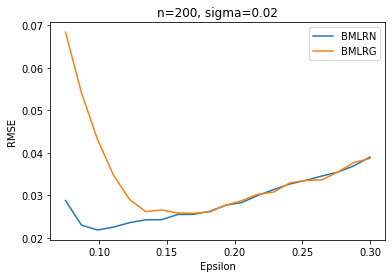

In [ ]:
rmses_eps = np.array(rmses_eps)
plt.plot(epsilon_list, rmses_eps[:, 0], label='BMLRN')
plt.plot(epsilon_list, rmses_eps[:, 1], label='BMLRG')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('n=200, sigma=0.02')
plt.legend()